$$
u_t + u_x = 0, \quad x \in [-1, 1]
$$

$$
u_0(x) =
\begin{cases}
\frac{1}{6} \left( G(x, \beta, z - \delta) + G(x, \beta, z + \delta) + 4G(x, \beta, z) \right) & x \in [-0.8, -0.6] \\
0 & x \in [-0.4, -0.2] \\
1 - \left| 10(x - 0.1) \right| & x \in [0.0, 0.2] \\
\frac{1}{6} \left( F(x, \alpha, a - \delta) + F(x, \alpha, a + \delta) + 4F(x, \alpha, a) \right) & 0.4 \geq x <0.6 \\
0 & \text{otherwise}
\end{cases}
$$

where $G(x,\beta, x) = e^{\beta(x-z)^2}, F(x, \alpha, a) = \sqrt{max(a-\alpha^2(x-a^2), 0)}, a=0.5, z=0.07, d=0.005, \beta = \frac{log 2}{36 \delta^2}$

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
from matplotlib.gridspec import GridSpec

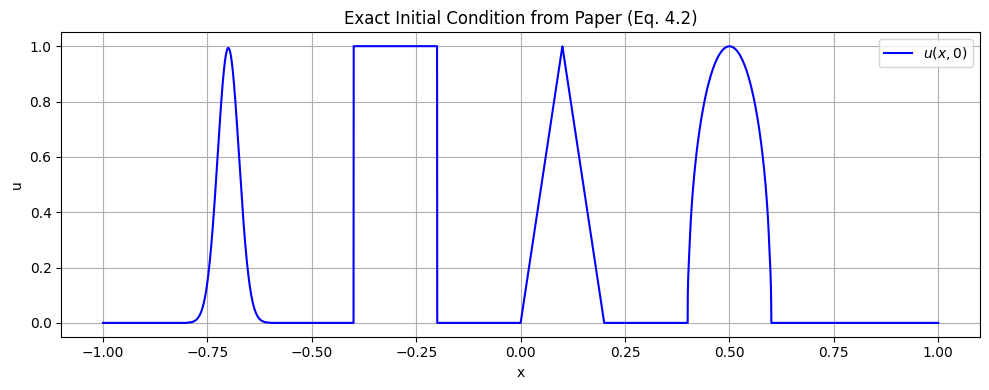

In [2]:
def Initial_condition(tx_ic):
    x = tx_ic[:, 1:2]  # Get x from second column now

    # Constants from the paper
    delta = 0.005
    z = -0.7
    a = 0.5
    alpha = 10.0
    beta = np.log(2.0) / (36.0 * delta**2)

    # G(x, beta, z)
    def G(x, beta, z):
        return np.exp(-beta * (x - z)**2)

    # F(x, alpha, a)
    def F(x, alpha, a):
        return np.sqrt(np.maximum(1.0 - alpha**2 * (x - a)**2, 0.0))

    # Conditions
    cond1 = np.logical_and(x >= -0.8, x < -0.6)
    cond2 = np.logical_and(x >= -0.4, x < -0.2)
    cond3 = np.logical_and(x >=  0.0, x <  0.2)
    cond4 = np.logical_and(x >=  0.4, x <  0.6)
    cond_else = np.logical_not(cond1 | cond2 | cond3 | cond4)

    # Values
    u1 = (1/6) * (G(x, beta, z - delta) + G(x, beta, z + delta) + 4 * G(x, beta, z))
    u2 = np.ones_like(x)
    u3 = 1.0 - np.abs(10.0 * (x - 0.1))
    u4 = (1/6) * (F(x, alpha, a - delta) + F(x, alpha, a + delta) + 4 * F(x, alpha, a))
    u5 = np.zeros_like(x)

    # Piecewise combination
    u0 = (
        u1 * cond1.astype(np.float32) +
        u2 * cond2.astype(np.float32) +
        u3 * cond3.astype(np.float32) +
        u4 * cond4.astype(np.float32) +
        u5 * cond_else.astype(np.float32)
    )

    return u0


# def Initial_condition(x_ic):
#     x = x_ic[:, 0:1]
#     return np.exp(-2*x**2) * (np.sin(8 * np.pi * x))**3

x = np.linspace(-1, 1, 10000).reshape(-1, 1)
t = np.zeros_like(x)
tx_ic = np.hstack([t, x])  # Note: t first, x second
u_ic = Initial_condition(np.array(tx_ic))

plt.figure(figsize=(10, 4))
plt.plot(x, u_ic, label=r'$u(x, 0)$', color='blue')
plt.title("Exact Initial Condition from Paper (Eq. 4.2)")
plt.xlabel("x")
plt.ylabel("u")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
N_bc=200
N_ic=100
n_f=20000
num_train_samples=10000
num_test_samples=2000

In [4]:
class Network:
  @classmethod
  def build(cls, num_inputs=2, num_outputs=1, layers=[16,32, 64, 128], optimizer='tanh'):
    inputs=tf.keras.layers.Input(shape=(num_inputs,))
    h1=tf.keras.layers.Dense(16, activation='tanh')(inputs)
    h2=tf.keras.layers.Dense(32, activation='tanh')(h1)
    h3=tf.keras.layers.Dense(64, activation='tanh')(h2)
    outputs=tf.keras.layers.Dense(num_outputs)(h3)
    return tf.keras.models.Model(inputs=inputs,outputs=outputs)
network=Network.build()
network.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,769 (10.82 KB)

 Trainable params: 2,769 (10.82 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class GradientLayer(tf.keras.layers.Layer):
  def __init__(self, model, **kwargs):
    self.model=model
    super().__init__(**kwargs)
  def call(self,x):
    with tf.GradientTape() as g:
      g.watch(x)
      with tf.GradientTape() as gg:
       gg.watch(x)
       u=self.model(x)
      du_dtx=gg.batch_jacobian(u,x)
      du_dt=du_dtx[...,0]
      du_dx=du_dtx[...,1]
    d2u_dx2=g.batch_jacobian(du_dx,x)[...,1]
    return u,du_dt,du_dx,d2u_dx2

In [6]:
class PINN:
  def __init__(self, network):
    self.network=network
    self.grads=GradientLayer(self.network)
  def build(self):
    tx_eqn=tf.keras.layers.Input(shape=(2,))
    tx_ini=tf.keras.layers.Input(shape=(2,))
    u, du_dt, du_dx, d2u_dx2 = self.grads(tx_eqn)
    u_eqn = du_dt + du_dx
    u_ini=self.network(tx_ini)
    return tf.keras.models.Model(inputs=[tx_eqn, tx_ini], outputs=[u_eqn, u_ini])
pinn=PINN(network).build()
pinn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gradient_layer      │ [(None, 1),       │      2,769 │ input_layer_1[0]… │
│ (GradientLayer)     │ (None, 1), (None, │            │                   │
│                     │ 1), (None, 1)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1)         │          0 │ gradient_layer[0… │
│                     │                   │            │ gradient_layer[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 1)         │      2,769 │ input_layer_2[0]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,769 (10.82 KB)

 Trainable params: 2,769 (10.82 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
tx_eqn = np.random.rand(num_train_samples,2)
tx_eqn[...,1] = 2 * tx_eqn[...,1] - 1
tx_eqn[...,0] = 8 * tx_eqn[...,0]

tx_ini=np.random.rand(num_train_samples,2)
tx_ini[...,1] = 2 * tx_ini[...,1] - 1
tx_ini[...,0] = 0

u_eqn = np.zeros((num_train_samples,1))

u_ini = Initial_condition(tx_ini)
# u_ini=-np.sin(np.pi *tx_ini[...,1])

u_ini=u_ini.reshape((10000,1))

Streaming output truncated to the last 5000 lines.
Iteration 811: Loss = 0.003532212460413575
Iteration 812: Loss = 0.003513886360451579
Iteration 813: Loss = 0.003513886360451579
Iteration 814: Loss = 0.003473745658993721
Iteration 815: Loss = 0.003473745658993721
Iteration 816: Loss = 0.003416265593841672
Iteration 817: Loss = 0.003416265593841672
Iteration 818: Loss = 0.0033776448108255863
Iteration 819: Loss = 0.0033776448108255863
Iteration 820: Loss = 0.0033501938451081514
Iteration 821: Loss = 0.0033501938451081514
Iteration 822: Loss = 0.003328824182972312
Iteration 823: Loss = 0.003328824182972312
Iteration 824: Loss = 0.003324649529531598
Iteration 825: Loss = 0.003324649529531598
Iteration 826: Loss = 0.003317945869639516
Iteration 827: Loss = 0.003317945869639516
Iteration 828: Loss = 0.003300479846075177
Iteration 829: Loss = 0.003300479846075177
Iteration 830: Loss = 0.0032728416845202446
Iteration 831: Loss = 0.0032728416845202446
Iteration 832: Loss = 0.0032534110359847

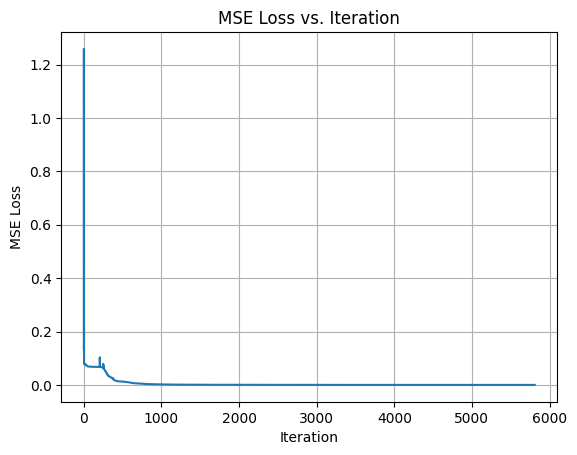

In [8]:
class L_BFGS_B:
    def __init__(self, model, x_train, y_train, m=50, factr=1e7, maxls=50, maxiter=10000):
        self.model = model
        self.x_train = [tf.constant(x, dtype=tf.float32) for x in x_train]
        self.y_train = [tf.constant(y, dtype=tf.float32) for y in y_train]
        self.factr = factr
        self.m = m
        self.loss_values = []
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        self.progbar = tf.keras.callbacks.ProgbarLogger()

        # self.progbar = tf.keras.callbacks.ProgbarLogger(
        #     count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params({
            'verbose': 1, 'epochs': 1, 'steps': self.maxiter, 'metrics': self.metrics
        })

    def set_weights(self, flat_weights):
        shapes = [w.shape for w in self.model.get_weights()]
        split_ids = np.cumsum([np.prod(shape) for shape in shapes])
        weights = [flat_weights[from_id:to_id].reshape(shape)
                   for from_id, to_id, shape in zip(np.hstack([[0], split_ids[:-1]]), split_ids, shapes)]
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):
        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        self.set_weights(weights)
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        loss = loss.numpy().astype('float64')
        self.loss_values.append(loss)  # Append loss to the list
        grads = np.concatenate([g.numpy().flatten() for g in grads]).astype('float64')
        return loss, grads

    def callback(self, weights):
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        initial_weights = np.concatenate(
            [w.flatten() for w in self.model.get_weights()])
        print('Optimizer : L_BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
                                     factr=self.factr, m=self.m, maxls=self.maxls, maxiter=self.maxiter,
                                     callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()

        # Print loss values
        for i, loss in enumerate(self.loss_values):
            print(f'Iteration {i+1}: Loss = {loss}')

        # Plot loss values
        plt.plot(self.loss_values)
        plt.xlabel('Iteration')
        plt.ylabel('MSE Loss')
        plt.title('MSE Loss vs. Iteration')
        plt.grid(True)
        plt.show()

# Example usage:
# Define your model and data
x_train = [tx_eqn, tx_ini]
y_train = [u_eqn, u_ini]
model = pinn  # Your neural network model

lbfgs = L_BFGS_B(model=model, x_train=x_train, y_train=y_train)
lbfgs.fit()

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


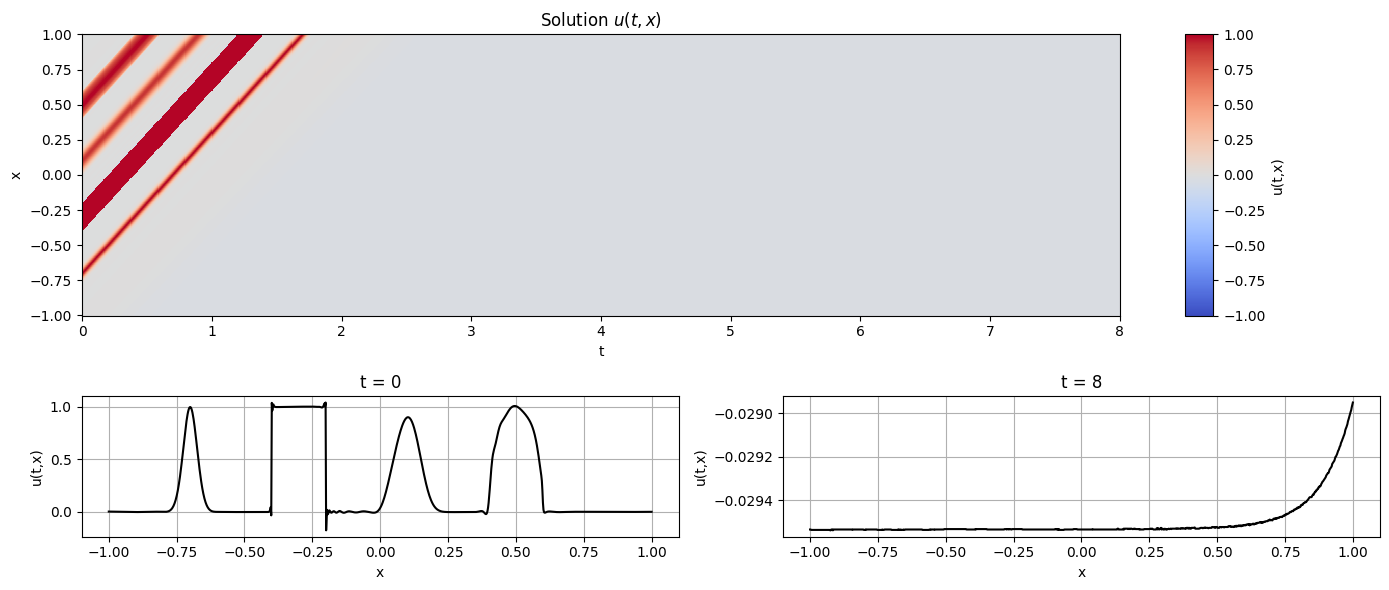

In [16]:
from matplotlib.gridspec import GridSpec
num_train_samples = 1000

t_flat = np.linspace(0, 8, num_train_samples)
x_flat = np.linspace(-1, 1, num_train_samples)
t, x = np.meshgrid(t_flat, x_flat)

tx = np.stack([t.flatten(), x.flatten()], axis=-1)

# Predict u(t,x) over the grid
u = network.predict(tx, batch_size=num_test_samples)
u = u.reshape(t.shape)

# Plot 2D color map of u(t,x)
fig = plt.figure(figsize=(14, 6))
gs = GridSpec(2, 2, height_ratios=[2, 1])

# Top subplot (full width)
ax0 = fig.add_subplot(gs[0, :])
pcm = ax0.pcolormesh(t, x, u, shading='auto', cmap='coolwarm')
ax0.set_xlabel('t')
ax0.set_ylabel('x')
ax0.set_title('Solution $u(t,x)$')
cbar = plt.colorbar(pcm, ax=ax0, pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
pcm.set_clim(-1, 1)

# Cross-section plots at t=0 and t=8
t_cross_sections = [0, 8]

for i, t_cs in enumerate(t_cross_sections):
    ax = fig.add_subplot(gs[1, i])
    tx_cs = np.stack([np.full_like(x_flat, t_cs), x_flat], axis=-1)
    u_cs = network.predict(tx_cs, batch_size=num_test_samples)
    ax.plot(x_flat, u_cs, color='black')
    ax.set_title(f't = {t_cs}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(t,x)')
    ax.grid(True)

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


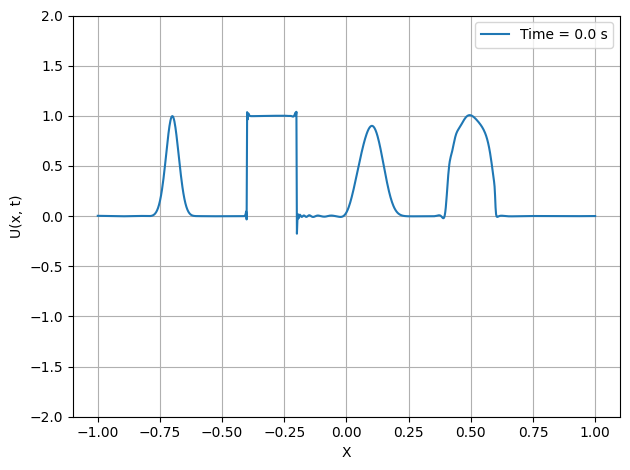

In [11]:
import matplotlib.animation as animation
from matplotlib.widgets import Slider
from IPython.display import HTML

fig, ax = plt.subplots()

# FIXED: Ensure t_cross_sections is not empty
t_cross_sections = np.arange(0, 8.0, 0.1)
artists = []

def update_slider(i):
    if i >= len(t_cross_sections):  # Prevent IndexError
        return
    ax.clear()
    ax.grid(True)  # Fixed grid syntax
    t_ = t_cross_sections[i]

    tx = np.stack([np.full(x_flat.shape, t_), x_flat], axis=-1)
    batch_size = min(len(tx), 32)  # Use a valid batch size
    u = network.predict(tx, batch_size=batch_size)

    ax.plot(x_flat, u, label=f'Time = {round(t_, 2)} s')
    ax.set_ylim([-2, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('U(x, t)')
    ax.legend(loc='best')
    plt.tight_layout()

anim = animation.FuncAnimation(fig, update_slider, frames=len(t_cross_sections), blit=False, repeat=True)

# Save animation
animation_file = 'animation.mp4'
anim.save(animation_file, writer='ffmpeg', fps=10)  # Adjust fps to reasonable value

# Display animation in Jupyter Notebook
HTML(anim.to_html5_video())  # Better compatibility


# Jax

In [12]:
!pip install jax jaxlib optax matplotlib


Epoch 0, Loss: 1.29867e+00
Epoch 100, Loss: 1.57677e-01
Epoch 200, Loss: 1.29508e-01
Epoch 300, Loss: 1.18654e-01
Epoch 400, Loss: 1.12093e-01
Epoch 500, Loss: 1.07300e-01
Epoch 600, Loss: 1.03277e-01
Epoch 700, Loss: 1.02479e-01
Epoch 800, Loss: 9.63914e-02
Epoch 900, Loss: 9.37559e-02


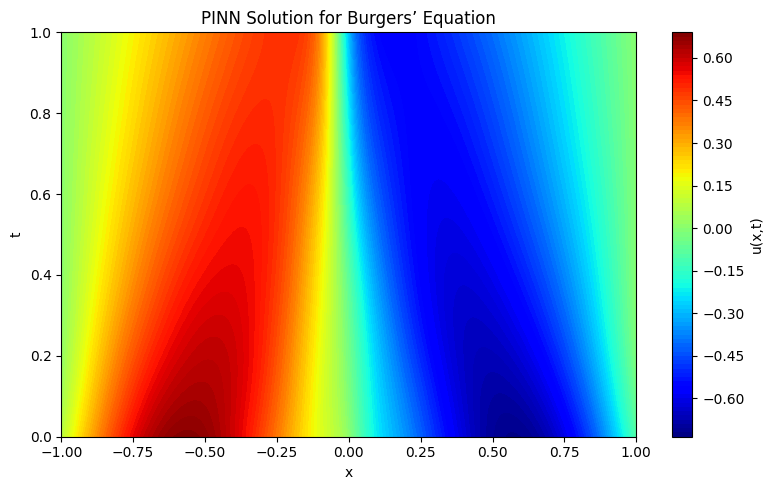

In [13]:
import jax
import jax.numpy as np
import optax
import matplotlib.pyplot as plt
from jax import grad, vmap, jit, random
from functools import partial

key = random.PRNGKey(0)
nu = 0.01 / np.pi  # viscosity

# ------------------ Neural Network ------------------ #
def init_network_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, k in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        W = random.normal(k, (n, m)) * np.sqrt(2.0 / m)
        b = np.zeros((n,))
        params.append((W, b))
    return params

def neural_net(params, x):
    for W, b in params[:-1]:
        x = np.tanh(np.dot(W, x) + b)
    W, b = params[-1]
    return np.dot(W, x) + b

# Batched version: x shape (N, 2)
@jit
def predict(params, xt):
    def single_forward(x): return neural_net(params, x)
    return vmap(single_forward)(xt)

# ------------------ PDE Residual ------------------ #
def burgers_residual(params, xt):
    x, t = xt[0], xt[1]

    def u_fn(xt): return neural_net(params, xt).squeeze()

    u = u_fn(np.array([x, t]))
    u_x = grad(lambda x_: u_fn(np.array([x_, t])))(x)
    u_t = grad(lambda t_: u_fn(np.array([x, t_])))(t)
    u_xx = grad(lambda x_: grad(lambda x__: u_fn(np.array([x__, t])))(x_))(x)

    return u_t + u * u_x - nu * u_xx

v_residual = vmap(lambda params, xt: burgers_residual(params, xt), in_axes=(None, 0))

# ------------------ Loss Function ------------------ #
@jit
def loss_fn(params, xt_eqn, xt_ic, u_ic, xt_bc):
    res = v_residual(params, xt_eqn)
    loss_eqn = np.mean(res**2)

    u_pred_ic = predict(params, xt_ic).squeeze()
    loss_ic = np.mean((u_pred_ic - u_ic)**2)

    u_bc = predict(params, xt_bc).squeeze()
    loss_bc = np.mean(u_bc**2)

    return loss_eqn + loss_ic + loss_bc

# ------------------ Data Generation ------------------ #
N_f = 5000
N_ic = 200
N_bc = 200

x = np.linspace(-1, 1, 256)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)

key, subkey = random.split(key)
xt_eqn = random.uniform(subkey, (N_f, 2), minval=np.array([-1.0, 0.0]), maxval=np.array([1.0, 1.0]))

key, subkey = random.split(key)
x_ic = random.uniform(subkey, (N_ic,), minval=-1.0, maxval=1.0)
t_ic = np.zeros_like(x_ic)
u_ic = -np.sin(np.pi * x_ic)
xt_ic = np.stack([x_ic, t_ic], axis=1)

key, subkey = random.split(key)
t_bc = random.uniform(subkey, (N_bc,))
xt_bc = np.vstack([
    np.stack([np.full_like(t_bc, -1.0), t_bc], axis=1),
    np.stack([np.full_like(t_bc, 1.0), t_bc], axis=1),
])

# ------------------ Training ------------------ #
layer_sizes = [2, 64, 64, 64, 1]
params = init_network_params(layer_sizes, key)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

@jit
def update(params, opt_state, xt_eqn, xt_ic, u_ic, xt_bc):
    loss, grads = jax.value_and_grad(loss_fn)(params, xt_eqn, xt_ic, u_ic, xt_bc)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

losses = []
for epoch in range(1000):
    params, opt_state, loss = update(params, opt_state, xt_eqn, xt_ic, u_ic, xt_bc)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.5e}")

# ------------------ Prediction ------------------ #
xt_test = np.stack([X.flatten(), T.flatten()], axis=1)
u_pred = predict(params, xt_test).reshape(X.shape)

# ------------------ Plot ------------------ #
plt.figure(figsize=(8, 5))
plt.contourf(X, T, u_pred, 100, cmap='jet')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN Solution for Burgers’ Equation')
plt.tight_layout()
plt.show()


In [14]:
# Time slices to inspect
time_slices = [0.0, 8.0]

plt.figure(figsize=(10, 6))

for t_val in time_slices:
    # Find the closest time index in the predicted time grid
    idx = np.argmin(np.abs(t - t_val))

    plt.plot(x_test, u_pred[idx], label=f'PINN t={t_val}')

plt.title("PINN Prediction of u(x,t) at Selected Times")
plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'x_test' is not defined

<Figure size 1000x600 with 0 Axes>

# Num_train_samples = 1000
# Num_ini_samples = 100
# AF = tanh

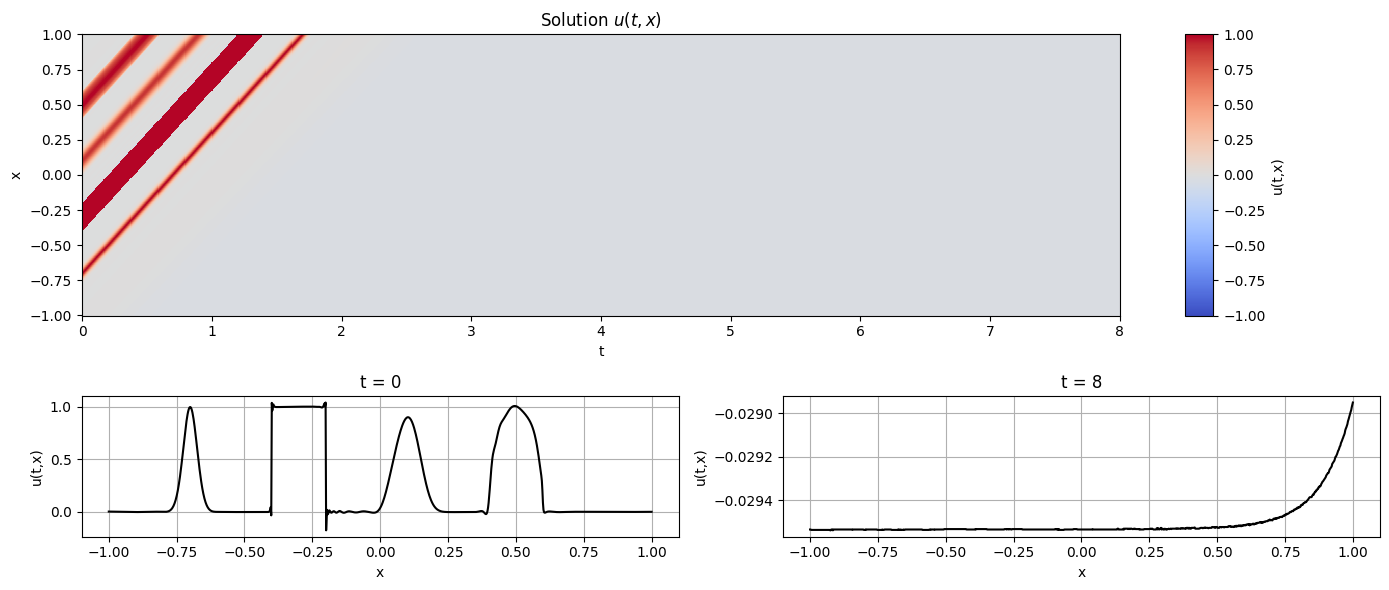

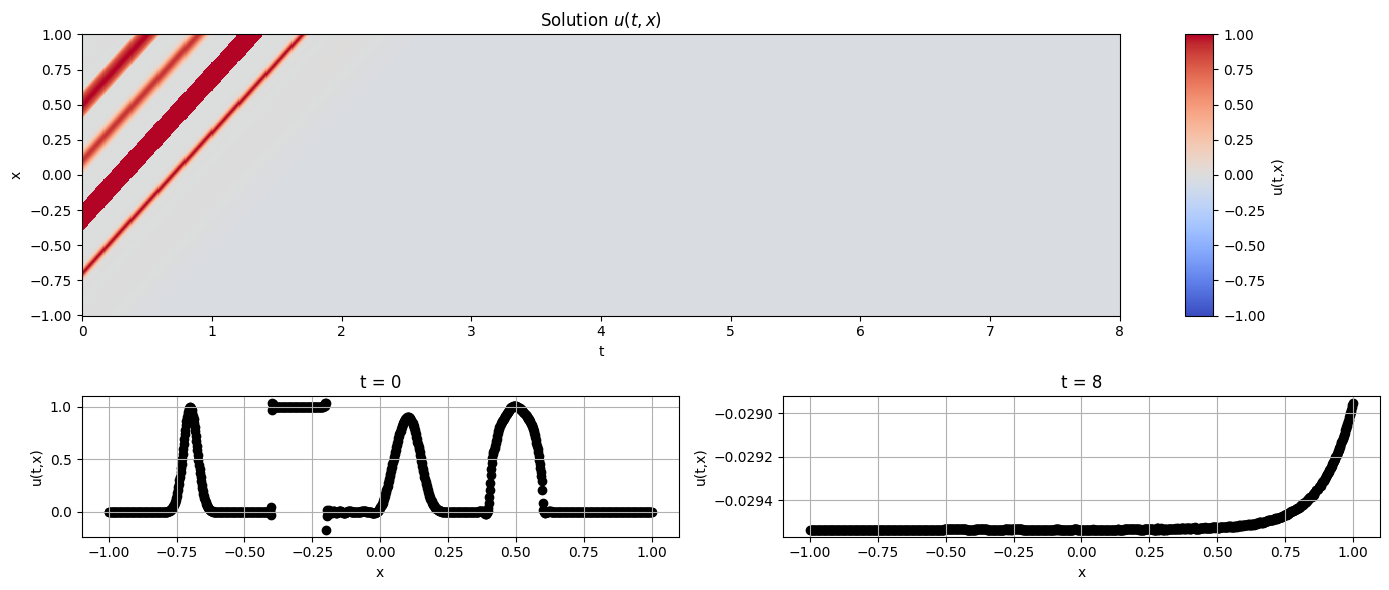

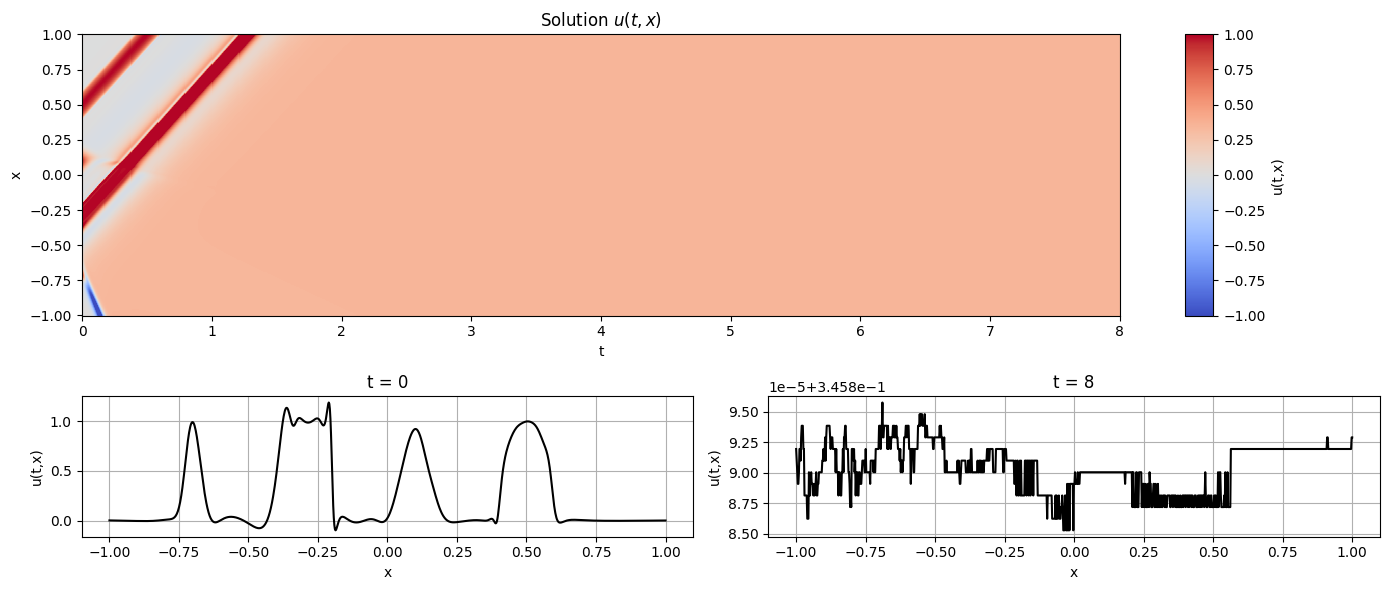